# Decision Trees

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import cross_validation
from sklearn import tree as Tree
from sklearn import ensemble
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
import sklearn.tree
%matplotlib inline 

//anaconda/envs/CaGRIN/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load in data

In [30]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/test.csv',index_col=0)

In [31]:
data.head(5)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision
0,10.0,0.0,10.0,0.0,0.0,1.0,1.0,2.023,0.339,1.0,...,1.0,1.670,0.308,1.0,1.0,2.240,0.304,2.452,0.355,1.0
1,10.0,0.0,10.0,0.0,0.0,1.0,1.0,2.405,0.342,1.0,...,1.0,2.240,0.304,1.0,1.0,2.452,0.355,2.225,0.334,1.0
2,10.0,0.0,10.0,0.0,0.0,1.0,1.0,6.294,0.450,1.0,...,1.0,2.452,0.355,1.0,1.0,2.225,0.334,2.323,0.301,1.0
3,10.0,0.0,10.0,0.0,0.0,1.0,1.0,1.670,0.308,1.0,...,1.0,2.225,0.334,1.0,1.0,2.323,0.301,2.255,0.429,1.0
4,10.0,0.0,10.0,0.0,0.0,1.0,1.0,2.240,0.304,1.0,...,1.0,2.323,0.301,1.0,1.0,2.255,0.429,2.124,0.309,1.0


In [70]:
np.sum(data.duplicated())

4115

In [71]:
data.shape[0]

8406

In [68]:
data.loc[10,:]

Previous_10_Left_Choice     10.000
Previous_10_Right_Choice     0.000
Previous_10_Left_Reward      9.000
Previous_10_Right_Reward     0.000
Streak                       3.000
5_Port                       1.000
5_Reward                     1.000
5_ITI                        2.145
5_trialDuration              0.458
4_Port                       1.000
4_Reward                     0.000
4_ITI                        1.844
4_trialDuration              0.561
3_Port                       1.000
3_Reward                     1.000
3_ITI                        1.089
3_trialDuration              0.384
2_Port                       1.000
2_Reward                     1.000
2_ITI                        2.187
2_trialDuration              0.280
1_Port                       1.000
1_Reward                     1.000
1_ITI                        1.533
1_trialDuration              0.565
0_ITI                        2.250
Decision                     0.000
Name: 10, dtype: float64

In [32]:
data = data.drop('0_trialDuration',axis=1)
data.head(2)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Port,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision
0,10.0,0.0,10.0,0.0,0.0,1.0,1.0,2.023,0.339,1.0,...,1.0,1.0,1.67,0.308,1.0,1.0,2.240,0.304,2.452,1.0
1,10.0,0.0,10.0,0.0,0.0,1.0,1.0,2.405,0.342,1.0,...,1.0,1.0,2.24,0.304,1.0,1.0,2.452,0.355,2.225,1.0


In [34]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

# Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch

In [35]:
y_diff = np.diff(y)
x = x[1:,:]
y = np.abs(y_diff)

print(x.shape)
print(y_diff.shape)

(8406, 26)
(8406,)


## Use only outcome features

In [36]:
data = data.iloc[1:,:]
data['Decision'] = y

outcome_features = ['Streak','5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Decision']

data_outcome = data[outcome_features]

x = data_outcome.iloc[:,:-1].values
y = data_outcome.iloc[:,-1].values

#uncomment if you want to run on all features
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [37]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [38]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 5884 | # switches: 391 --> 6.6 percent
# test trials: 2522 | # switches: 197 --> 7.8 percent


# Decision Tree with all outcome features

In [58]:
tree = Tree.DecisionTreeClassifier(max_depth = 20,class_weight='balanced')
tree.fit(x_train,y_train)
y_predict = tree.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         2263.0           62.0
True YES          57.0          140.0

F1: 0.702

Accuracy on class 0: 0.97
Accuracy on class 1: 0.71



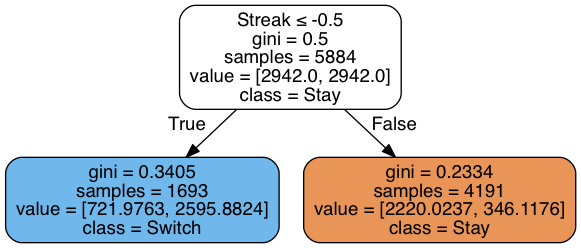

In [40]:
dot_data = Tree.export_graphviz(tree,out_file=None,
                     feature_names=data.columns.values[:-1],
                     class_names = ['Stay','Switch'],
                     filled=True,rounded=True,special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

This isn't sensitive to max_depth i.e. it does not improve for any number > 1. 

In [41]:
tree.feature_importances_

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [72]:
D = np.arange(1,20)

acc_cv = []

for i,d in enumerate(D):
    tree = Tree.DecisionTreeClassifier(max_depth=d,class_weight='balanced')

    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0

    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        tree.fit(x_train_cv,y_train_cv)
        y_predict = tree.predict(x_test_cv)

        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

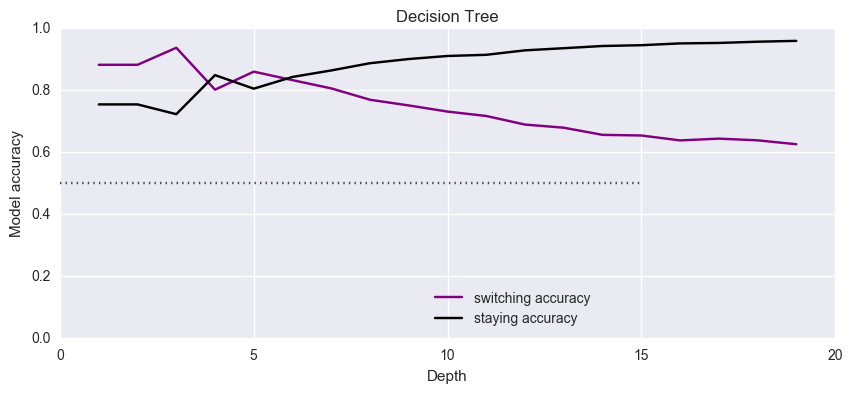

In [74]:
plt.figure(figsize=(10,4))
plt.plot(D,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(D,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=15,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.ylim(0,1)
plt.xlabel('Depth')
plt.ylabel('Model accuracy')
plt.title('Decision Tree')

# Try boosting single feature decision trees

In [42]:
# boosting: many many weak classifiers (max_depth=1) refine themselves sequentially
# tree is the default the base classifier
estimator = ensemble.GradientBoostingClassifier(n_estimators=10, learning_rate=1, max_depth=3, random_state=0)
estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_pred,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         2234.0           91.0
True YES         103.0           94.0

F1: 0.492

Accuracy on class 0: 0.96
Accuracy on class 1: 0.48



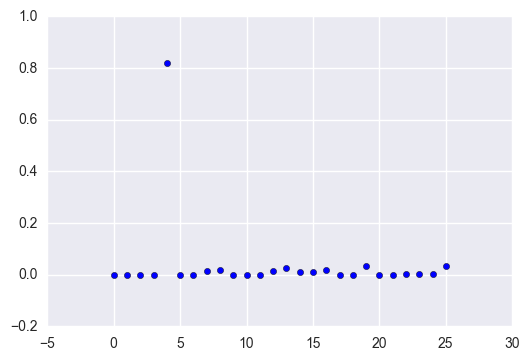

In [43]:
plt.scatter(np.arange(estimator.feature_importances_.shape[0]),estimator.feature_importances_)

# Benchmark model --> what if we just predict the mouse switches every time it doesn't get a reward?

In [44]:
data_outcome.columns.get_loc('2_Reward')

4

In [45]:
y_predict = (x_test[:,4] == 0).astype('int')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         2160.0          165.0
True YES         194.0            3.0

F1: 0.016

Accuracy on class 0: 0.93
Accuracy on class 1: 0.02



In [46]:
print('# of testing switches')
np.sum(y_test)

# of testing switches


197.0

In [47]:
print('# of testing trials with 1_Reward == 1')
np.sum(x_test[:,22])

# of testing trials with 1_Reward == 1


1799.0

In [48]:
print('# of test trials with 1_Reward == 0')
np.sum(x_test[:,22] == 0)

# of test trials with 1_Reward == 0


723

In [49]:
print('# of test switches when 1_Reward == 0')
np.sum(y_test[x_test[:,22] == 0])

# of test switches when 1_Reward == 0


171.0